# Explore Dropout and L2 Regularization Techniques to Combat Overfitting

## Data Preprocessing

In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import randn
import pathlib
import random
from PIL import Image
import cv2
from matplotlib.image import imread
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/PranavM98/Facial-Detection-and-Emotion-Classifier.git

Cloning into 'Facial-Detection-and-Emotion-Classifier'...
remote: Enumerating objects: 87358, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 87358 (delta 59), reused 148 (delta 58), pack-reused 87206
Receiving objects: 100% (87358/87358), 345.70 MiB | 12.35 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Checking out files: 100% (134181/134181), done.


In [32]:
#Image Folder
data_dir = pathlib.Path("/content/Facial-Detection-and-Emotion-Classifier/00_Data/01_Transformed_Data/Resized_Emotion_Images/")

In [33]:
#Emotion Labels
label_names={'happy':0,
            'sad':1,
            'neutral':2
}

In [34]:
#Saving images into a list img_data
img_data=[]
count=0
all_images = list(data_dir.glob('*'))
all_labels=[]
kernel = np.array([[0, -1, 0],
              [-1, 5,-1],
              [0, -1, 0]])

wrong_emotion=['disgust','fear','surprise','fea','angry']
for i in all_images:
  a=str(i)[str(i).rfind('/')+1:]
  emotion=a[:a.find('_')]

  if emotion not in wrong_emotion :
    img=Image.open(str(i))
    #Resize Images
    img=img.resize((64,64))
    img=np.array(img).astype('float64')
    #img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    img=img/255
    img_data.append(img)


In [35]:
#Augmented Data

from google.colab.patches import cv2_imshow


'''
Sharpening the Image by convolving with the filter

'''
kernel = np.array([[0, -1, 0],
              [-1, 5,-1],
              [0, -1, 0]])

aug_img_data=[]
for i in img_data:
  image_sharp = cv2.filter2D(src=i, ddepth=-1, kernel=kernel)
  aug_img_data.append(image_sharp)



In [36]:
#All labels - 0, 1, 2
data=pd.read_csv("/content/Facial-Detection-and-Emotion-Classifier/00_Data/01_Transformed_Data/emotion_label.csv")

all_images = list(data_dir.glob('*'))
all_labels=[]
for i in all_images:
  file=str(i)[str(i).rfind('/')+1:]
  
  a=str(i)[str(i).rfind('/')+1:]
  emotion=a[:a.find('_')]

  if emotion not in wrong_emotion:
    all_labels.append(label_names[data[data['Filename']==file]['label'].values[0]])

In [37]:
#number of images in each label 0- happy, 1 - sad, 2 - neutral
pd.Series(all_labels).value_counts()

0    8989
2    6198
1    6077
dtype: int64

In [9]:
#Setting Seed
tf.random.set_seed(
    5
)

In [38]:
#Masking
top_mask=[]
bottom_mask=[]
three_fourth_mask=[]
def creating_mask():
    a=np.array([0]*2048)
    a=a.reshape((32,64))
    b=np.array([1]*2048)
    b=b.reshape((32,64))
    return a,b


for i in img_data:
    a,b=creating_mask()
    con_bot = np.concatenate((b,a),axis=0)
    con_top = np.concatenate((a,b),axis=0)
    #bottom_mask.append(np.multiply(con_bot,i))
    #top_mask.append(np.multiply(con_top,i))
    bottom_mask.append(i[:32,:])
    top_mask.append(i[32:,:])
    three_fourth_mask.append(i[16:,:])



In [39]:
import pickle


In [67]:
#No Mask
data_size=len(all_images)

train_test_split=(int)(data_size*0.2)

x_train=img_data[train_test_split:]
x_test=img_data[:train_test_split]

y_train=all_labels[train_test_split:]
y_test=all_labels[:train_test_split]




In [68]:

kernel = np.array([[0, -1, 0],
              [-1, 5,-1],
              [0, -1, 0]])

aug_x_train=[]
for i in x_train:
  image_sharp = cv2.filter2D(src=i, ddepth=-1, kernel=kernel)
  aug_x_train.append(image_sharp)

In [69]:
len(aug_x_train)

14087

In [70]:

for i in range(len(x_train)):
    x_train[i]=x_train[i].reshape((64,64,1))


for i in range(len(x_test)):
    x_test[i]=x_test[i].reshape((64,64,1))


for i in range(len(aug_x_train)):
    aug_x_train[i]=aug_x_train[i].reshape((64,64,1))





In [71]:
#Creating final X and Y train datasets
final_x_train=x_train+aug_x_train
final_y_train=y_train+y_train

In [72]:
#----
final_x=final_x_train+x_test
final_y=final_y_train+y_test
final_train_dataset = tf.data.Dataset.from_tensor_slices((np.asarray(final_x), np.array(final_y)))


In [73]:
#creating final datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((np.asarray(final_x_train), np.array(final_y_train)))
test_dataset = tf.data.Dataset.from_tensor_slices((np.asarray(x_test), np.array(y_test)))

## VGG-16 Model

### Regularization

In [19]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras import Model

In [20]:
input = Input(shape=(64,64,1))

In [21]:
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(input)
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(x)
x=MaxPool2D(pool_size =2, strides =2, padding ='same')(x)


In [22]:
x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding= 'same')(x)


In [23]:
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)


In [24]:
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)


x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)



In [25]:
x=Flatten()(x)
x=Dense(units=4096, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x=Dense(units=4096, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x=Dense(units=1000, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
output=Dense(units=3, activation='softmax')(x)

In [26]:
model=Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                             

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)


In [28]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

final_train_dataset = final_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=25,
                                            restore_best_weights=True, mode='max')
history_regularization=model.fit(train_dataset, epochs=25, validation_data=(test_dataset),callbacks=[callback])

Epoch 1/25
441/441 [==============================] - 36s 59ms/step - loss: 1.3340 - sparse_categorical_accuracy: 0.4243 - val_loss: 1.0789 - val_sparse_categorical_accuracy: 0.4811
Epoch 2/25
441/441 [==============================] - 25s 57ms/step - loss: 0.8719 - sparse_categorical_accuracy: 0.5760 - val_loss: 0.8358 - val_sparse_categorical_accuracy: 0.5894
Epoch 3/25
441/441 [==============================] - 25s 57ms/step - loss: 0.7315 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.6359
Epoch 4/25
441/441 [==============================] - 25s 57ms/step - loss: 0.6603 - sparse_categorical_accuracy: 0.6884 - val_loss: 0.7370 - val_sparse_categorical_accuracy: 0.6465
Epoch 5/25
441/441 [==============================] - 25s 57ms/step - loss: 0.5924 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.7565 - val_sparse_categorical_accuracy: 0.6531
Epoch 6/25
441/441 [==============================] - 25s 56ms/step - loss: 0.5161 - spars

In [283]:
history

In [47]:
input = Input(shape=(64,64,1))
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(input)
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(x)
x=MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding= 'same')(x)

x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x=Dropout(0.05)(x)

x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x=Dropout(0.05)(x)

x=Flatten()(x)
x=Dense(units=4096, activation='relu')(x)
x=Dense(units=4096, activation='relu')(x)
x=Dense(units=1000, activation='relu')(x)
output=Dense(units=3, activation='softmax')(x)

model_drop=Model(inputs=input, outputs=output)
model_drop.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 128)       147584    
                                                           

In [48]:
model_drop.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

final_train_dataset = final_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=25,
                                            restore_best_weights=True, mode='max')
history_drop=model_drop.fit(train_dataset, epochs=25, validation_data=(test_dataset),callbacks=[callback])

Epoch 1/25
441/441 [==============================] - 25s 54ms/step - loss: 1.0587 - sparse_categorical_accuracy: 0.4416 - val_loss: 0.9876 - val_sparse_categorical_accuracy: 0.4969
Epoch 2/25
441/441 [==============================] - 24s 54ms/step - loss: 0.8009 - sparse_categorical_accuracy: 0.6064 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.6064
Epoch 3/25
441/441 [==============================] - 24s 54ms/step - loss: 0.6993 - sparse_categorical_accuracy: 0.6660 - val_loss: 0.7734 - val_sparse_categorical_accuracy: 0.6369
Epoch 4/25
441/441 [==============================] - 24s 54ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.7424 - val_sparse_categorical_accuracy: 0.6590
Epoch 5/25
441/441 [==============================] - 24s 54ms/step - loss: 0.5630 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.6623
Epoch 6/25
441/441 [==============================] - 24s 54ms/step - loss: 0.4903 - spars

#### Regularization + Dropout

In [57]:
input = Input(shape=(64,64,1))
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(input)
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(x)
x=MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding= 'same')(x)

x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x=Dropout(0.05)(x)

x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x=Dropout(0.05)(x)

x=Flatten()(x)
x=Dense(units=4096, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x=Dense(units=4096, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x=Dense(units=1000, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
output=Dense(units=3, activation='softmax')(x)

model_regdrop=Model(inputs=input, outputs=output)
model_regdrop.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 128)       147584    
                                                           

In [58]:
model_regdrop.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

final_train_dataset = final_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=25,
                                            restore_best_weights=True, mode='max')
history_regdrop=model_regdrop.fit(train_dataset, epochs=25, validation_data=(test_dataset),callbacks=[callback])

Epoch 1/25
441/441 [==============================] - 26s 57ms/step - loss: 1.2430 - sparse_categorical_accuracy: 0.4920 - val_loss: 1.0229 - val_sparse_categorical_accuracy: 0.5134
Epoch 2/25
441/441 [==============================] - 25s 57ms/step - loss: 0.8071 - sparse_categorical_accuracy: 0.6249 - val_loss: 0.7940 - val_sparse_categorical_accuracy: 0.6175
Epoch 3/25
441/441 [==============================] - 25s 57ms/step - loss: 0.7064 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.7513 - val_sparse_categorical_accuracy: 0.6418
Epoch 4/25
441/441 [==============================] - 25s 57ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.7960 - val_sparse_categorical_accuracy: 0.6334
Epoch 5/25
441/441 [==============================] - 25s 56ms/step - loss: 0.5662 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.8367 - val_sparse_categorical_accuracy: 0.6416
Epoch 6/25
441/441 [==============================] - 25s 56ms/step - loss: 0.4879 - spars

In [120]:
#reconstructed_model = keras.models.load_model("my_model")

In [59]:
y_pred=model_regdrop.predict(np.asarray(x_test))
y_preds=np.argmax(y_pred,axis=1)

In [60]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [61]:
confusion_matrix(y_test,y_preds)

array([[2600,  248,  160],
       [ 270, 1322,  447],
       [ 364,  695, 1071]])

In [62]:
accuracy_score(y_test,y_preds)

0.6956945799080396

In [63]:
f1_score(y_test,y_preds,average='weighted')

0.6906188127408965

In [64]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3008
           1       0.58      0.65      0.61      2039
           2       0.64      0.50      0.56      2130

    accuracy                           0.70      7177
   macro avg       0.68      0.67      0.67      7177
weighted avg       0.69      0.70      0.69      7177



### Original Model

In [65]:
input = Input(shape=(64,64,1))
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(input)
x=Conv2D(filters=64,kernel_size=3, padding='same',activation='relu')(x)
x=MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding= 'same')(x)

x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)

x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)


x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu')(x)
x=MaxPool2D(pool_size=2, strides=2, padding='same')(x)


x=Flatten()(x)
x=Dense(units=4096, activation='relu')(x)
x=Dense(units=4096, activation='relu')(x)
x=Dense(units=1000, activation='relu')(x)
output=Dense(units=3, activation='softmax')(x)

model_original=Model(inputs=input, outputs=output)
model_original.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 128)       147584    
                                                           

In [74]:
model_original.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

final_train_dataset = final_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=25,
                                            restore_best_weights=True, mode='max')
history_original=model_original.fit(train_dataset, epochs=25, validation_data=(test_dataset),callbacks=[callback])

Epoch 1/25
441/441 [==============================] - 25s 54ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.4240 - val_loss: 1.0832 - val_sparse_categorical_accuracy: 0.4191
Epoch 2/25
441/441 [==============================] - 24s 54ms/step - loss: 1.0806 - sparse_categorical_accuracy: 0.4235 - val_loss: 1.0768 - val_sparse_categorical_accuracy: 0.4290
Epoch 3/25
441/441 [==============================] - 24s 54ms/step - loss: 1.0791 - sparse_categorical_accuracy: 0.4257 - val_loss: 1.0811 - val_sparse_categorical_accuracy: 0.4191
Epoch 4/25
441/441 [==============================] - 24s 53ms/step - loss: 0.9316 - sparse_categorical_accuracy: 0.5270 - val_loss: 0.9109 - val_sparse_categorical_accuracy: 0.5321
Epoch 5/25
441/441 [==============================] - 24s 54ms/step - loss: 0.7475 - sparse_categorical_accuracy: 0.6436 - val_loss: 0.7751 - val_sparse_categorical_accuracy: 0.6196
Epoch 6/25
441/441 [==============================] - 24s 54ms/step - loss: 0.6604 - spars

In [88]:
train_accuracy_original=[0.4961, 0.6426, 0.6953, 0.7415, 0.7811, 0.8210, 0.8536, 0.8871, 0.9209, 0.9375, 0.9529, 0.9691, 0.9725, 0.9760, 0.9796, 0.9850, 0.9864, 
                         0.9875, 0.9884, 0.9868, 0.9885, 0.9882, 0.9890, 0.9901, 0.9922]

val_accuracy_original=[0.5392, 0.6122, 0.5880, 0.6682, 0.6572, 0.6705, 0.7002, 0.7120, 0.7091, 0.7052, 0.7070, 0.7042, 0.6865, 0.6862,
 0.7116, 0.7148, 0.7119, 0.7134, 0.7131, 0.7103, 0.7048, 0.7158, 0.7031, 0.7223, 0.7231]

In [87]:
len(train_accuracy_original)

24

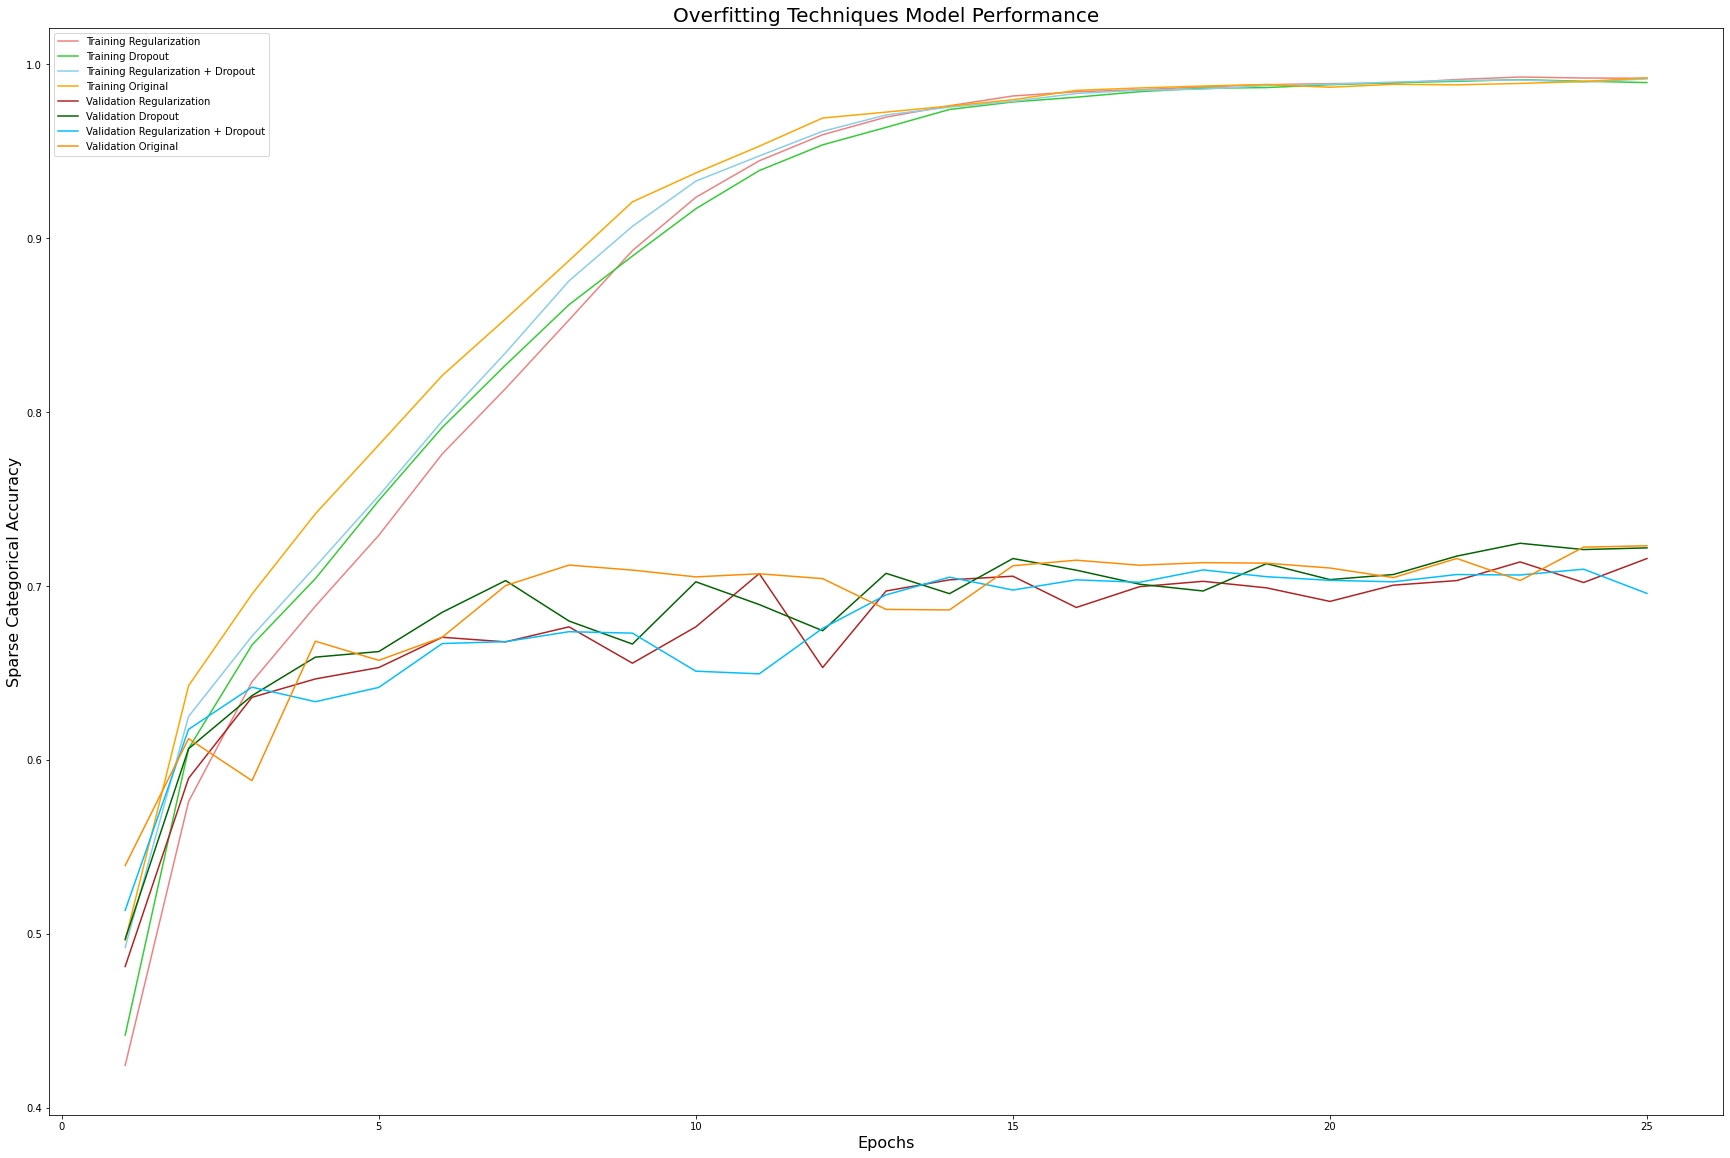

In [95]:
plt.figure(figsize=(30,20))
plt.plot(range(1,26),history_regularization.history['sparse_categorical_accuracy'], label='Training Regularization',color='lightcoral')
plt.plot(range(1,26),history_drop.history['sparse_categorical_accuracy'], label='Training Dropout', color='limegreen')
plt.plot(range(1,26),history_regdrop.history['sparse_categorical_accuracy'], label='Training Regularization + Dropout', color='skyblue')
plt.plot(range(1,26),train_accuracy_original, label='Training Original',color='orange')

plt.plot(range(1,26),history_regularization.history['val_sparse_categorical_accuracy'], label='Validation Regularization', color='firebrick')
plt.plot(range(1,26),history_drop.history['val_sparse_categorical_accuracy'], label='Validation Dropout',color='darkgreen')
plt.plot(range(1,26),history_regdrop.history['val_sparse_categorical_accuracy'], label='Validation Regularization + Dropout',color='deepskyblue')
plt.plot(range(1,26),val_accuracy_original, label='Validation Original', color='darkorange')
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Sparse Categorical Accuracy",fontsize=16)
plt.title("Overfitting Techniques Model Performance",fontsize=20)
plt.legend()

